In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
from joblib import dump
from IPython.display import IFrame
import tempfile
import warnings
warnings.filterwarnings('ignore')
# import dask.dataframe as dd


In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [4]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_test_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_test_train_lag{ndays}_pre_processing.csv', index_col=None)
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))

In [6]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(67714, 93) (67714, 1) (45368, 93) (45368, 1) (22346, 93) (22346, 1)


### Build Decision Tree and Improve in valid set

In [8]:
dt_model = DecisionTreeRegressor(random_state=42, **best_params['dt_grid_search'].item())
dt_model.fit(X_train, y_train)
dump(dt_model, f'{save_dir}/dt_model_tuning.joblib')



DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=10, random_state=42)

In [9]:
dt_valid_predictions = dt_model.predict(X_valid)
dt_valid_mae = mean_absolute_error(y_valid, dt_valid_predictions)
dt_valid_r2 = r2_score(y_valid, dt_valid_predictions)
print(f"Decision Tree - Validation MAE: {dt_valid_mae:.3f}, Validation R2: {dt_valid_r2:.3f}")


Decision Tree - Validation MAE: 0.119, Validation R2: 0.900


In [15]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

In [12]:
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature {X.columns[index]} ({importances[index]})")

Feature ranking:
1. feature installed_capacity (0.47938242346702287)
2. feature segment (0.39445400001587666)
3. feature surface_solar_radiation_downwards_fl (0.030901910454612172)
4. feature is_consumption (0.02422149482589443)
5. feature is_business (0.017473572380747104)
6. feature prediction_unit_id (0.007261009549714078)
7. feature eic_count (0.0041390404390381575)
8. feature data_block_id_right (0.0036295254210616276)
9. feature surface_solar_radiation_downwards (0.003309682057961776)
10. feature cos(dayofyear) (0.002898343283171862)
11. feature direct_solar_radiation_hd_7d (0.0026437449432877265)
12. feature direct_solar_radiation (0.0018565859632250826)
13. feature county (0.0017655303892496956)
14. feature direct_solar_radiation_fl (0.0013260470097545428)
15. feature euros_per_mwh (0.001083585373572907)
16. feature cloudcover_low_fl (0.0008698027366507929)
17. feature temperature_fd_7d (0.0008533790494214014)
18. feature winddirection_10m (0.0008385637356733224)
19. feature lo

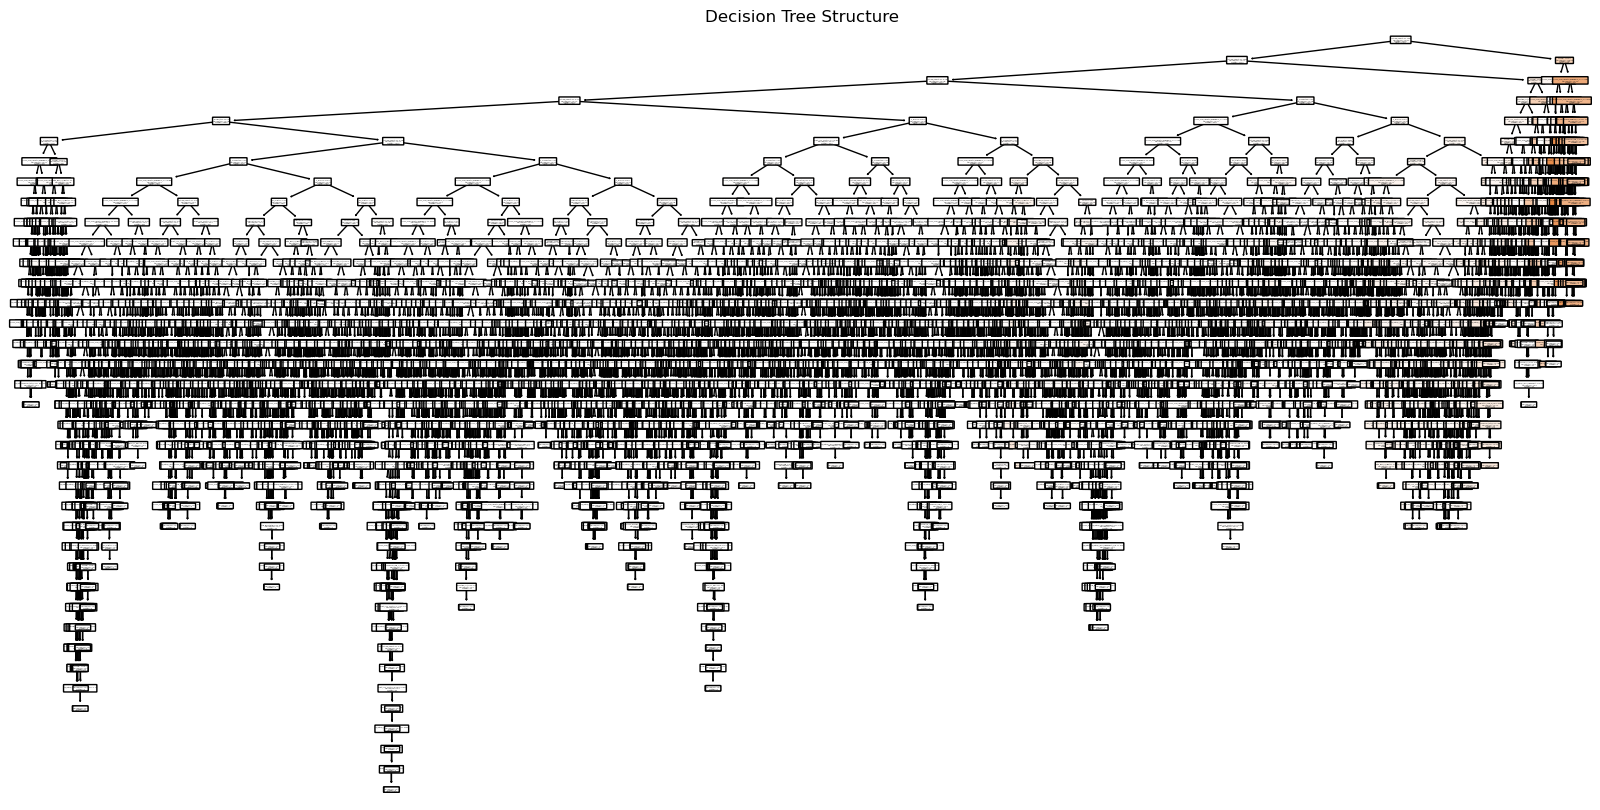

In [19]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

### Use LIME, SHAP to explained

 97%|=================== | 21729/22346 [00:13<00:00]       

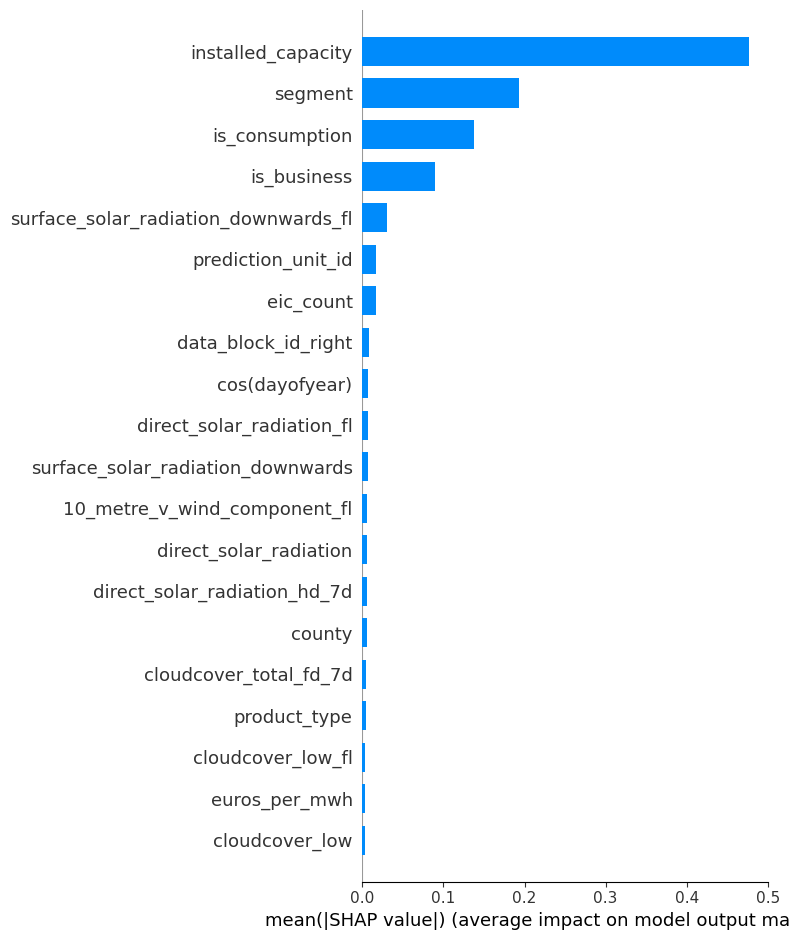

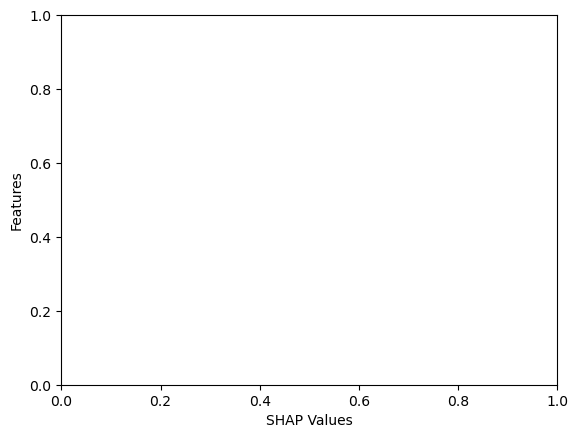

In [33]:
explainer_dt = shap.Explainer(dt_model, X_train)
shap_values_dt = explainer_dt(X_valid, check_additivity=False)


shap.summary_plot(shap_values_dt, X_valid, plot_type="bar", title="SHAP Decision Tree Feature Importance")


In [41]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_dt = explainer.explain_instance(X_valid.iloc[0].values, dt_model.predict)
file_name = f"{save_dir}/lime_explanation_dt.html"

lime_exp_dt.save_to_file(file_name)
lime_exp_dt.show_in_notebook()


### Build LGBM and Improve in valid set

In [21]:
# Train LightGBM model
lgbm_model = lgb.LGBMRegressor(objective='regression',**best_params['lgb_grid_search'].item())
lgbm_model.fit(X_train, y_train)
dump(lgbm_model, f'{save_dir}/lgbm_model_tuning.joblib')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21293
[LightGBM] [Info] Number of data points in the train set: 45368, number of used features: 93
[LightGBM] [Info] Start training from score -0.025777


LGBMRegressor(n_estimators=200, num_leaves=50, objective='regression')

In [22]:
lgbm_model_predictions = lgbm_model.predict(X_valid)
lgbm_model_mae = mean_absolute_error(y_valid, lgbm_model_predictions)
lgbm_model_r2 = r2_score(y_valid, lgbm_model_predictions)
print(f"LGBM model - Validation MAE: {lgbm_model_mae:.3f}, Validation R2: {lgbm_model_r2:.3f}")

LGBM model - Validation MAE: 0.118, Validation R2: 0.904


### Use LIME, SHAP to explained

In [ ]:
explainer_lgbm = shap.Explainer(lgbm_model, X_train)
shap_values_lgbm = explainer_lgbm(X_valid, check_additivity=False)


shap.summary_plot(shap_values_lgbm, X_valid, plot_type="bar", title="SHAP LGBM Feature Importance")



In [42]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_lgbm = explainer.explain_instance(X_valid.iloc[0].values, lgbm_model.predict)
file_name = f"{save_dir}/lime_explanation_lgbm.html"

lime_exp_lgbm.save_to_file(file_name)
lime_exp_lgbm.show_in_notebook()
